# House Prices - Advanced Regression Techniques
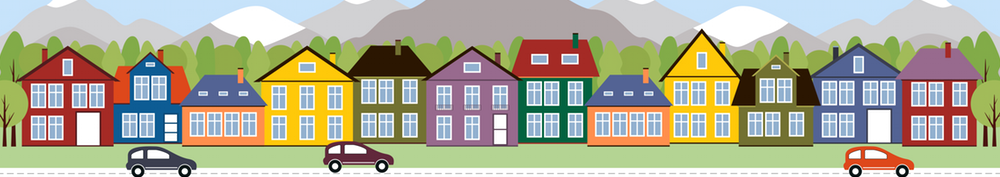

Необходимо на основе датасета из 79 признаков предсказать цену дома

In [ ]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [71]:
from zipfile import ZipFile
zip_file = ZipFile('C:/Users/Настя/Documents/Python/houses.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

# Exploratory data analysis

Загрузка тренировочного датасета

In [72]:
train=dfs['train.csv']
test=dfs['test.csv']
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Размер датасета

In [73]:
train.shape

(1460, 81)

In [74]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Информация о пропусках

In [75]:
cols={'number':train.isnull().sum(),'percent':train.isnull().sum()*100/train.shape[0]}
miss_val=pd.DataFrame(cols)
miss_val.sort_values(by='percent',ascending=False).head(10)

,number,percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


Есть признаки, в которых много пропущенных значений. Удалю признаки, где пропусков больше 47 процентов.

In [76]:
train=train.dropna(axis=1,thresh=train.shape[0]*0.55)
test=test.dropna(axis=1,thresh=train.shape[0]*0.55)
train.shape

(1460, 76)

In [77]:
test.shape

(1459, 75)

Целевая переменная

In [78]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

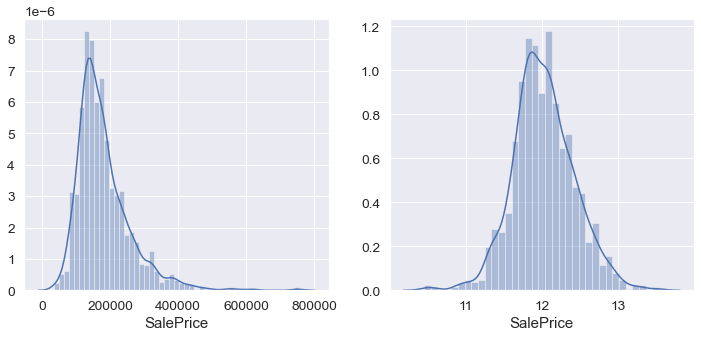

In [79]:
plt.subplots(figsize=(12, 5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'])
plt.subplot(1,2,2)
sns.distplot(np.log(train['SalePrice']))

Преобразуем распределение в нормальное, так некоторые модели будут работать лучше

In [80]:
train['SalePrice']=np.log(train['SalePrice'])

В датасете немало переменных, разделим их на категориальные и числовые

In [81]:
feature_num = train.drop(['Id','SalePrice'],axis=1).select_dtypes(include=[np.number]).columns
feature_cat = train.select_dtypes(exclude=[np.number]).columns
print(len(feature_num),len(feature_cat))

36 38


Зависимость целевой переменной и числовых признаков

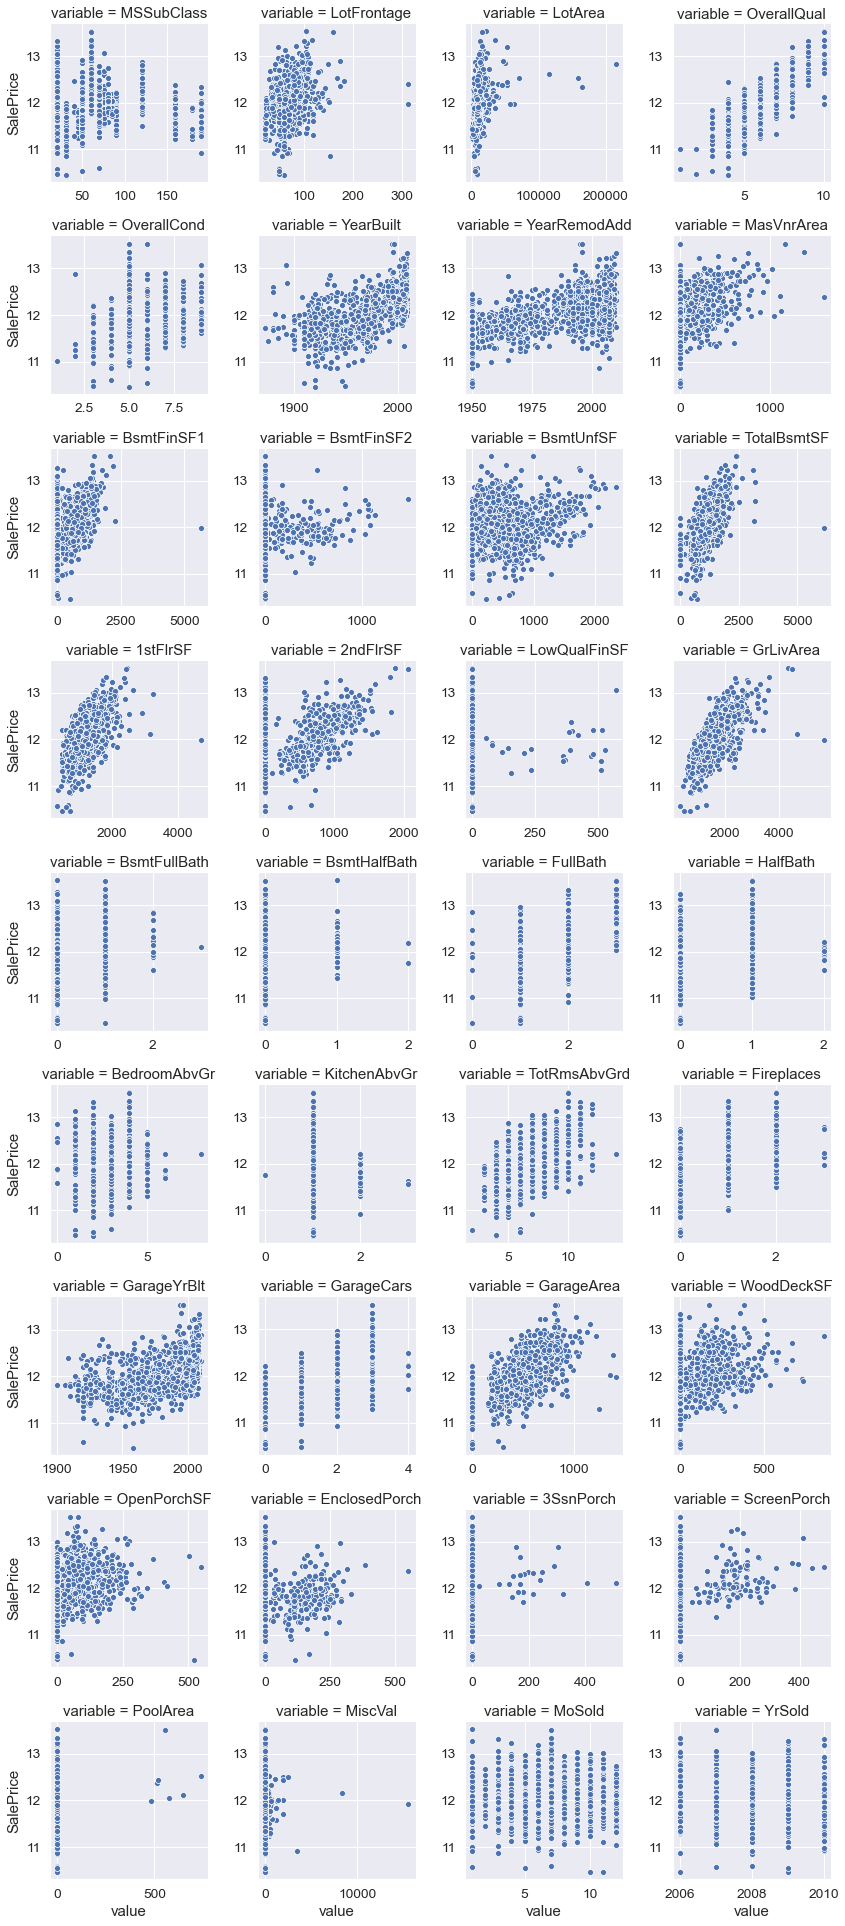

In [82]:
nd_num = pd.melt(train, id_vars='SalePrice', value_vars = feature_num)
n1 = sns.FacetGrid(nd_num, col='variable', col_wrap=4, sharex=False, sharey=False)
n1 = n1.map(sns.scatterplot, 'value', 'SalePrice')

- 1) Многие признаки коррелируют с целевой переменной
- 2) У многих признаков есть выбросы, от которых необходимо избавиться

Зависимость целевой переменной и категориальных признаков

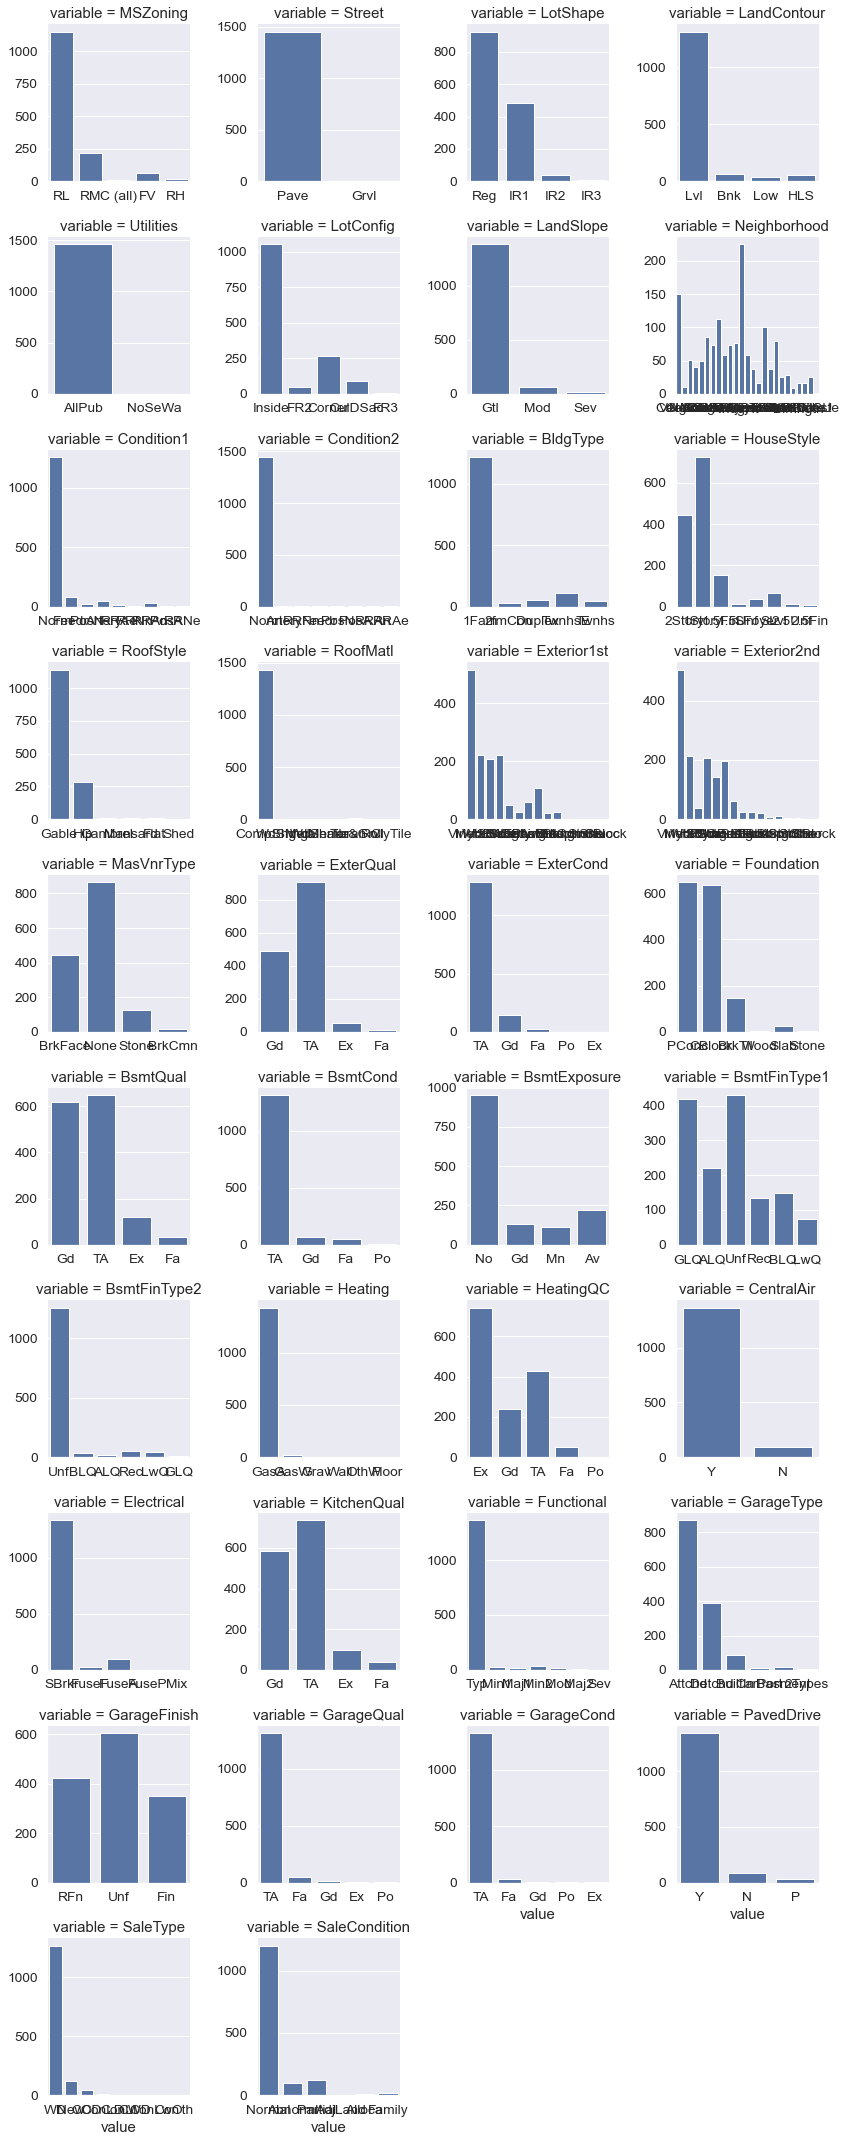

In [83]:
nd_cat = pd.melt(train, value_vars = feature_cat)
n2 = sns.FacetGrid(nd_cat, col='variable', col_wrap=4, sharex=False, sharey=False)
n2 = n2.map(sns.countplot, 'value')

- Также, как и в числовых переменных, есть сильнокоррелирующие признаки

# Предобработка данных

Заполнение пропущенных значений

In [84]:
mvn=train[feature_num].isnull().sum()/train.shape[0]*100
mvn=mvn[mvn>0]
mvn.sort_values(ascending=False)

LotFrontage    17.739726
GarageYrBlt     5.547945
MasVnrArea      0.547945
dtype: float64

In [85]:
mvc=train[feature_cat].isnull().sum()/train.shape[0]*100
mvc=mvc[mvc>0]
mvc.sort_values(ascending=False)

GarageCond      5.547945
GarageQual      5.547945
GarageFinish    5.547945
GarageType      5.547945
BsmtFinType2    2.602740
BsmtExposure    2.602740
BsmtFinType1    2.534247
BsmtCond        2.534247
BsmtQual        2.534247
MasVnrType      0.547945
Electrical      0.068493
dtype: float64

Заполним пропуски в числовых переменных медианой, а в категориальных - 'None'

In [86]:
for i in feature_num:
    med=train[i].median()
    test[i].fillna(med,inplace=True)
    train[i].fillna(med,inplace=True)
for x in feature_cat:
    train[x].fillna('None',inplace=True)
    test[x].fillna('None',inplace=True)

Проверка

In [87]:
train.isnull().sum().sum()

0

In [88]:
test.isnull().sum().sum()

0

Удаление выбросов

In [89]:
train.drop(train[train.GrLivArea>4500].index, inplace=True)
train.drop(train[train.LotFrontage>300].index, inplace=True)
train.drop(train[train.LotArea>100000].index, inplace=True)
train.drop(train[train.MasVnrArea>1500].index, inplace=True)
train.drop(train[train.OpenPorchSF>500].index, inplace=True)
train.drop(train[train.EnclosedPorch>400].index, inplace=True)
train.drop(train[train['1stFlrSF']>4000].index, inplace=True)
train.drop(train[train.TotalBsmtSF>4000].index, inplace=True)

Проверка

In [90]:
train.shape

(1448, 76)

# Корреляция признаков

In [91]:
corr=train.corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.824083
GrLivArea        0.724790
GarageCars       0.680925
GarageArea       0.654882
TotalBsmtSF      0.648010
1stFlrSF         0.618217
YearBuilt        0.597927
FullBath         0.593856
YearRemodAdd     0.568909
TotRmsAbvGrd     0.536178
GarageYrBlt      0.509329
Fireplaces       0.487096
MasVnrArea       0.439979
BsmtFinSF1       0.392576
LotArea          0.363555
LotFrontage      0.360549
OpenPorchSF      0.356987
WoodDeckSF       0.337959
2ndFlrSF         0.319039
HalfBath         0.318546
BsmtFullBath     0.233726
BsmtUnfSF        0.223907
BedroomAbvGr     0.204988
ScreenPorch      0.118538
PoolArea         0.071947
MoSold           0.062071
3SsnPorch        0.056074
BsmtFinSF2      -0.002021
BsmtHalfBath    -0.010304
Id              -0.016113
MiscVal         -0.023253
YrSold          -0.034487
OverallCond     -0.043137
LowQualFinSF    -0.043536
MSSubClass      -0.076391
KitchenAbvGr    -0.148065
EnclosedPorch   -0.153318
Name: SalePr

Построим теперь корреляционную матрицу

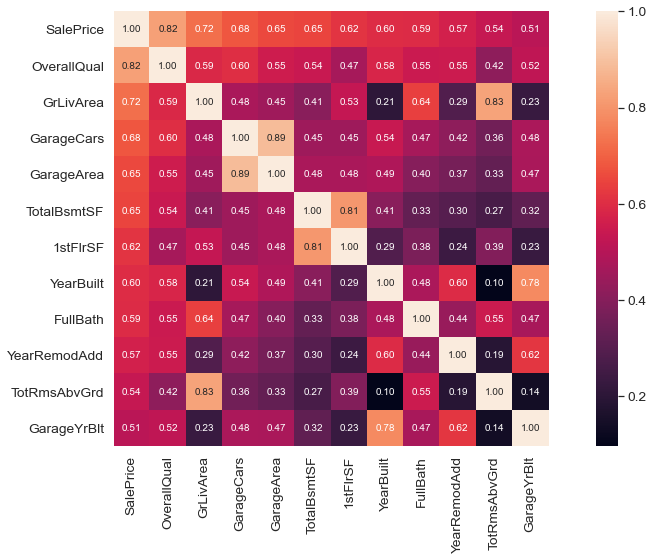

In [92]:
plt.figure(figsize=(17,8))
cols = corr.nlargest(12, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

Некоторые переменные очень сильно коррелируют друг с другом, из-за чего возникает проблема мультиколинеарности. Удалю те, у которых коэффициент корреляции превышает 0.75

In [93]:
df=train
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)] 
to_drop

['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'SalePrice']

In [94]:
train.drop(['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'],axis=1,inplace=True)
test.drop(['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'],axis=1,inplace=True)

In [95]:
train.shape,test.shape

((1448, 73), (1459, 72))

# Кодировка признаков


Многие категориальные признаки имеют порядковый вид, их переведем в числовой вид

In [96]:
qual_dict1 = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

train['HeatingQC'] = train['HeatingQC'].map(qual_dict1)
test['HeatingQC'] = test['HeatingQC'].map(qual_dict1)

train['ExterCond'] = train['ExterCond'].map(qual_dict1)
test['ExterCond'] = test['ExterCond'].map(qual_dict1)

train['ExterQual'] = train['ExterQual'].map(qual_dict1)
test['ExterQual'] = test['ExterQual'].map(qual_dict1)

train['KitchenQual'] = train['KitchenQual'].map(qual_dict1)
test['KitchenQual'] = test['KitchenQual'].map(qual_dict1)

train['GarageCond'] = train['GarageCond'].map(qual_dict1)
test['GarageCond'] = test['GarageCond'].map(qual_dict1)

train['GarageQual'] = train['GarageQual'].map(qual_dict1)
test['GarageQual'] = test['GarageQual'].map(qual_dict1)

qual_dict2 = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

train['BsmtFinType1'] = train['BsmtFinType1'].map(qual_dict2)
test['BsmtFinType1'] = test['BsmtFinType1'].map(qual_dict2)

train['BsmtFinType2'] = train['BsmtFinType2'].map(qual_dict2)
test['BsmtFinType2'] = test['BsmtFinType2'].map(qual_dict2)

qual_dict3 = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

train['GarageFinish'] = train.GarageFinish.map(qual_dict3)
test['GarageFinish'] = test.GarageFinish.map(qual_dict3)

qual_dict4 = {'None':0, 'Reg': 1, 'IR1':2, 'IR2':3, 'IR3': 4}

train['LotShape'] = train.LotShape.map(qual_dict4)
test['LotShape'] = test.LotShape.map(qual_dict4)

feature_ordinal=['HeatingQC', 'ExterCond', 'ExterQual', 'KitchenQual', 'GarageCond', 'GarageQual','BsmtFinType1','BsmtFinType2','GarageFinish','LotShape']


Удалим из новых числовых признаков сильно коррелируемые

In [97]:
feature_ordinal=['HeatingQC', 'ExterCond', 'ExterQual', 'KitchenQual', 'GarageCond', 'GarageQual','BsmtFinType1','BsmtFinType2','GarageFinish','LotShape']
df1=train[feature_ordinal]
# Create correlation matrix
corr_matrix1 = df1.corr().abs()

# Select upper triangle of correlation matrix
upper1 = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop1 = [column for column in upper1.columns if any(upper1[column] > 0.8)] 
to_drop1
train.drop('GarageQual',axis=1,inplace=True)
test.drop('GarageQual',axis=1,inplace=True)

Закодируем оставшиеся категориальные переменные

In [98]:
df=train.append(test)
df=pd.get_dummies(df)
df.shape

(2907, 241)

Разделим снова выборки на тестовую и тренировочную

In [108]:
df_train=df[:len(train)]
df_test=df[len(train):]
df_test.drop(['SalePrice'],axis=1,inplace=True)

# Выбор модели и обучение

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

**Случайный лес**

In [111]:
X=df_train.drop('SalePrice',axis=1)
y=df_train['SalePrice']
rf=RandomForestRegressor(bootstrap=True, n_estimators=300,random_state=17)
np.sqrt(-cross_val_score(rf,X,y,scoring='neg_mean_squared_error',cv=5).mean())

0.13484719878763596

**Лассо регрессия**

In [112]:
model_Lasso = Lasso(random_state=42)
params_lasso = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
gd_sr = GridSearchCV(estimator=model_Lasso, param_grid=params_lasso, scoring='neg_mean_squared_error',cv=5)
gd_sr.fit(X, y)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'alpha': 0.0004}


In [117]:
model_Lasso = Lasso(alpha=0.0004, random_state=42)
np.sqrt(-cross_val_score(estimator=model_Lasso, X=X, y=y, scoring='neg_mean_squared_error', cv=5).mean())

0.11010837223578977

**Xgboost**

In [114]:
xgb=XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       random_state=42)
np.sqrt(-cross_val_score(estimator=xgb, X=X, y=y, scoring='neg_mean_squared_error', cv=5).mean())

0.11851864880356475

Наиболее лучшей моделью показало себя Лассо регрессия, хотя при более точном подборе гиперпараметров Xgboost мог сработать лучше

In [136]:
model_Lasso.fit(X,y)
predictions=np.exp(model_Lasso.predict(df_test))
output = pd.DataFrame({'Id': df_test.Id, 'SalePrice': predictions.astype(float)})
output.to_csv('houses_submission.csv', index=False)

In [137]:
output

,Id,SalePrice
0,1461,116542.652313
1,1462,149282.368127
2,1463,180681.594633
3,1464,199506.040208
4,1465,192555.212471
...,...,...
1454,2915,85639.940254
1455,2916,83319.898494
1456,2917,168348.339455
1457,2918,113174.862576
